<a href="https://colab.research.google.com/github/paulaminassian/MyProjects/blob/main/DataScience/Insurance_Project/Proyecto_Final_FraudeSeguros_Minassian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract


El dataset seleccionado para este trabajo corresponde a los datos de una aseguradora sobre los reclamos de accidentes automovilísticos registrados en el período de 3 años incluyendo una distinción sobre aquellos que fueron detectados como fraudulentos.

Esta destinado al departamento de análisis de la compañía aseguradora para luego de ser estudiado ser compartido con el equipos operativo y comercial. El mismo incluye la siguiente información para resolver el problema objetivo que consiste en entender las características y correlaciones de los casos fraudulentos para así detectar y también prevenir los mismos.

La base de datos incluye:


*   Detalles sobre el asegurado
*   Detalles sobre el autómovil
*   Detalles de la póliza que tenia el cliente
*   Detalles del accidente

Objetivo:
Analizar las caracteristicas de los siniestros y corelaciones entre las mismas para lograr detectar los casos fraudulentos que puedan presentarse ante la aseguradora a fin de rechazarlos y evitar perdidas comerciales por pagos que no corresponderían.


# Preguntas e Hipótesis de interes

* ¿Cuál es la proporcion de casos fraudulentos vs no fraudulentos?

* ¿Hay alguna relación entre la edad del asegurado, la cantidad de accidentes y la probabilidad de presentar reclamos fraudulentos?

* ¿Hay alguna relación entre el género y estado marital del asegurado y la probabilidad de presentar reclamos fraudulentos?

* ¿Cuál es la relacion entre Genero y Estado Civil con el DriverRating?

* ¿Existen patrones estacionales en la presentación de reclamos?

* ¿Hay dias de la semana con mayor/menor cantidad de accidentes?

* Proporcion de accidentes con peatones involucrados (se utilizara fuente de datos la API para contestar esta pregunta)

* ¿El valor del vehículo asegurado influye en la probabilidad de presentar reclamos fraudulentos?

* ¿En que area hay mayor cantidad de accidentes?

* En los casos de reclamos fraudulentos, ¿Hubo reclamos/accidentes anteriores?




# Codigo

## Importacion de librerias y datasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import scipy.stats as ss
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix as cm
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import learning_curve


In [ ]:
#establezco el estilo de los graficos de aqui en adelante
sns.set_style("ticks")
plt.style.use('seaborn-v0_8')

Adquisicion dataset de asgeguradora csv obtenido en Kaggle

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/Entregas'
df_insurance = pd.read_csv('Insurance.csv', sep = ',')


/content/gdrive/MyDrive/Colab Notebooks/Entregas


Adquisicion dataset via API

El dataset de la API sera utilizado solo para analizar la distribucion de peatones involucrados en accidentes segun la agencia de transito de USA de manera complementaria y a modo de ejemplo dentro del Notebook.
Por las caracteristicas de la informacion del mismo no se combinará con el dataset principal ni se utilizará para la presentacion ejecutiva ya que si bien estan relacionados, abarcan la tematica de los accidentes desde opticas diferentes, con diferentes variables y para diferentes años y lugares, y sin conexion con la variable target que es el fraude.

In [ ]:
url='https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=1,51&fromYear=2014&toYear=2015&minNumOfVehicles=1&maxNumOfVehicles=6&format=json'
respuesta = requests.get(url)
print(respuesta)

<Response [200]>


In [ ]:
texto = respuesta.text

In [ ]:
data = json.loads(texto)
results = data["Results"][0]
df_accidents = pd.DataFrame(results)

In [ ]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2898 entries, 0 to 2897
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CountyName     2898 non-null   object
 1   CrashDate      2898 non-null   object
 2   Fatals         2898 non-null   int64 
 3   Peds           2898 non-null   int64 
 4   Persons        2898 non-null   int64 
 5   St_Case        2898 non-null   int64 
 6   State          2898 non-null   int64 
 7   StateName      2898 non-null   object
 8   TotalVehicles  2898 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 203.9+ KB


In [ ]:
df_accidents.head(10)

,CountyName,CrashDate,Fatals,Peds,Persons,St_Case,State,StateName,TotalVehicles
0,JACKSON (71),/Date(1388556900000-0500)/,1,0,2,10001,1,Alabama,1
1,FRANKLIN (59),/Date(1388601000000-0500)/,1,0,1,10002,1,Alabama,1
2,TUSCALOOSA (125),/Date(1388563620000-0500)/,2,0,7,10003,1,Alabama,2
3,TALLADEGA (121),/Date(1388671200000-0500)/,1,0,5,10004,1,Alabama,3
4,CULLMAN (43),/Date(1388698200000-0500)/,1,0,1,10005,1,Alabama,1
5,CONECUH (35),/Date(1388732400000-0500)/,1,0,1,10006,1,Alabama,1
6,MOBILE (97),/Date(1388792400000-0500)/,1,0,2,10007,1,Alabama,3
7,BUTLER (13),/Date(1388834400000-0500)/,1,0,4,10008,1,Alabama,2
8,WALKER (127),/Date(1388867940000-0500)/,1,0,5,10009,1,Alabama,3
9,MONTGOMERY (101),/Date(1389048960000-0500)/,2,0,6,10010,1,Alabama,2


In [ ]:
df_accidents = df_accidents.drop(['CrashDate'], axis=1) #eliminamos la columna crashdate ya que por el formato no aporta info.

In [ ]:
df_accidents.head(10)

,CountyName,Fatals,Peds,Persons,St_Case,State,StateName,TotalVehicles
0,JACKSON (71),1,0,2,10001,1,Alabama,1
1,FRANKLIN (59),1,0,1,10002,1,Alabama,1
2,TUSCALOOSA (125),2,0,7,10003,1,Alabama,2
3,TALLADEGA (121),1,0,5,10004,1,Alabama,3
4,CULLMAN (43),1,0,1,10005,1,Alabama,1
5,CONECUH (35),1,0,1,10006,1,Alabama,1
6,MOBILE (97),1,0,2,10007,1,Alabama,3
7,BUTLER (13),1,0,4,10008,1,Alabama,2
8,WALKER (127),1,0,5,10009,1,Alabama,3
9,MONTGOMERY (101),2,0,6,10010,1,Alabama,2


## EDA

In [ ]:
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

**Glosario de las variables**


Age/Edad

MaritalStatuts/Estado Civil

Sex/Genero

DriverRating/Puntaje del Conductor

AgeOfVehicle/Antiguedad del autómovil

VehicleCategory/Categoria del autómovil

VehiclePrice/Precio del autómovil

Make/Marca del auto

PolicyType/Tipo de Póliza

Day/Día del accidente

Week/Semana del año del accidente

Year/Año

AccidentArea/Zona del accidente

FraudFound_P/si hubo fraude

Witness/Si hubo testigos

NumberofCars/Autos involucrados

AgentType/Si el fraude fue de alguien interno de la empresa o externo

PoliceReportFilled/si fue denunciado a la policia

PastNumberOfClaims/Si tuvo reclamos anteriores

Fault/quien fue el culpable del accidente

In [ ]:
df_insurance.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [ ]:
"Primeras Observaciones"

# PolicyNumber es lo mismo que el index, es un dato redundante, eliminamos la columna.
# RepNumber no aporta informacion relevante, tambien se eliminara.
#PolicyType es la concatenacion de Basepolicy y VehicleType, por eso sera eliminada

df_insurance = df_insurance.drop(columns = ['PolicyNumber', 'RepNumber','PolicyType'])


### Nulos

In [ ]:
# Chequeamos si hay nulos
nulos = df_insurance.isnull().sum().sum()
print(nulos)


0


In [ ]:
#Ahora reviso si hay valores incorrectos. Aunque no haya nulos, puede haber Ceros.
# Para eso, solicitamos los valores unicos de cada columna
# Encontramos el valor 0 en Age, Month Claimed y Week Claimed
for column in df_insurance:
  print(column)
  print(sorted(df_insurance[column].unique()), "\n")

Month
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonth
[1, 2, 3, 4, 5] 

DayOfWeek
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

Make
['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'] 

AccidentArea
['Rural', 'Urban'] 

DayOfWeekClaimed
['0', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

MonthClaimed
['0', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonthClaimed
[1, 2, 3, 4, 5] 

Sex
['Female', 'Male'] 

MaritalStatus
['Divorced', 'Married', 'Single', 'Widow'] 

Age
[0, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7

In [ ]:
## Revisamos que cantidad de valores son 0 para las 3 variables que mostaron dicho resultado.
len(df_insurance.loc[df_insurance.Age == 0])

320

In [ ]:
len(df_insurance.loc[df_insurance.DayOfWeekClaimed == 0])
len(df_insurance.loc[df_insurance.DayOfWeekClaimed == '0'])
# No esta 0 COMO NUMERO pero si como texto ('0')

1

In [ ]:
len(df_insurance.loc[df_insurance.MonthClaimed == 0])
len(df_insurance.loc[df_insurance.MonthClaimed == '0'])
# No esta 0 COMO NUMERO pero si como texto ('0')

1

In [ ]:
#Como los valores con 0 no son muchos respecto al dataset completo, procederemos a eliminarlos
df_insurance = df_insurance.drop(index=df_insurance[df_insurance['Age'] == 0].index)
df_insurance = df_insurance.drop(index=df_insurance[df_insurance['DayOfWeekClaimed'] == '0'].index)
df_insurance = df_insurance.drop(index=df_insurance[df_insurance['MonthClaimed'] == '0'].index)

In [ ]:
# Volvemos a revisar, ya no hay ceros. Tampoco hay nulos ni n/a.
for column in df_insurance:
    print(column)
    print(sorted(df_insurance[column].unique()),"\n")

Month
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonth
[1, 2, 3, 4, 5] 

DayOfWeek
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

Make
['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'] 

AccidentArea
['Rural', 'Urban'] 

DayOfWeekClaimed
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

MonthClaimed
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonthClaimed
[1, 2, 3, 4, 5] 

Sex
['Female', 'Male'] 

MaritalStatus
['Divorced', 'Married', 'Single', 'Widow'] 

Age
[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75

### Duplicados

In [ ]:
# Revisamos si hay duplicados.

duplicates = df_insurance.duplicated()

#hacemos un conteo de duplicados
num_duplicates = duplicates.sum()
#mostramos resultado en texto
if num_duplicates > 0:
  print('hay duplicados')
else:
  print('no hay duplicados')

no hay duplicados


### Outliers y desbalances

Primero chequearemos los valores en Age que serian los mas criticos a la hora de encontrar outliers dentro de las columnas numericas.
Si bien el grafico debajo marca algunos valores alejados de la mediana entre los 70 y 80 años, tiene logica que haya menos gente mayor considerando que hablamos de conductores.
No se ve ningun valor atipico tipo "160 años", por lo que los datos se mantendran como estan para mantener la integridad de la data

Text(0.5, 1.0, 'Distribucion Edades')

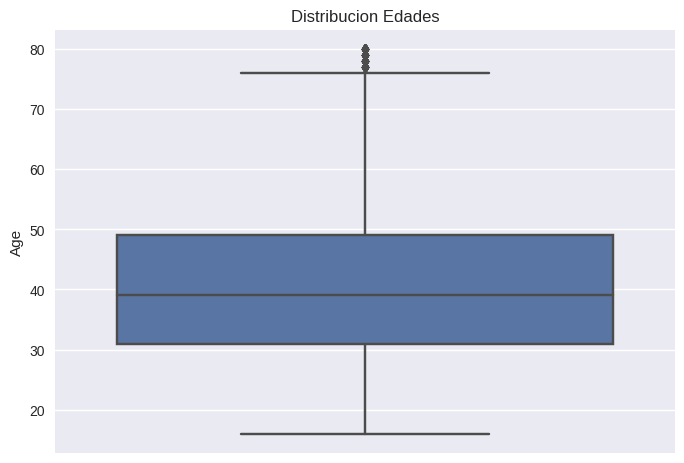

In [ ]:
sns.boxplot(y = 'Age', data = df_insurance)
plt.title('Distribucion Edades')

In [ ]:
# Para facilitar los siguientes analisis procedo a dividir las variables en numericas,
# categoricas y target (fraud found que como mencionado en el Glosario, indica si se encontro fraude o no)

variables_numericas = df_insurance[['Age', 'WeekOfMonth', 'Deductible','DriverRating','Year', 'WeekOfMonthClaimed']]
variables_categoricas=df_insurance.drop(['Age','Deductible','DriverRating','FraudFound_P','Year','WeekOfMonthClaimed','WeekOfMonth'],axis=1)
target=df_insurance['FraudFound_P']

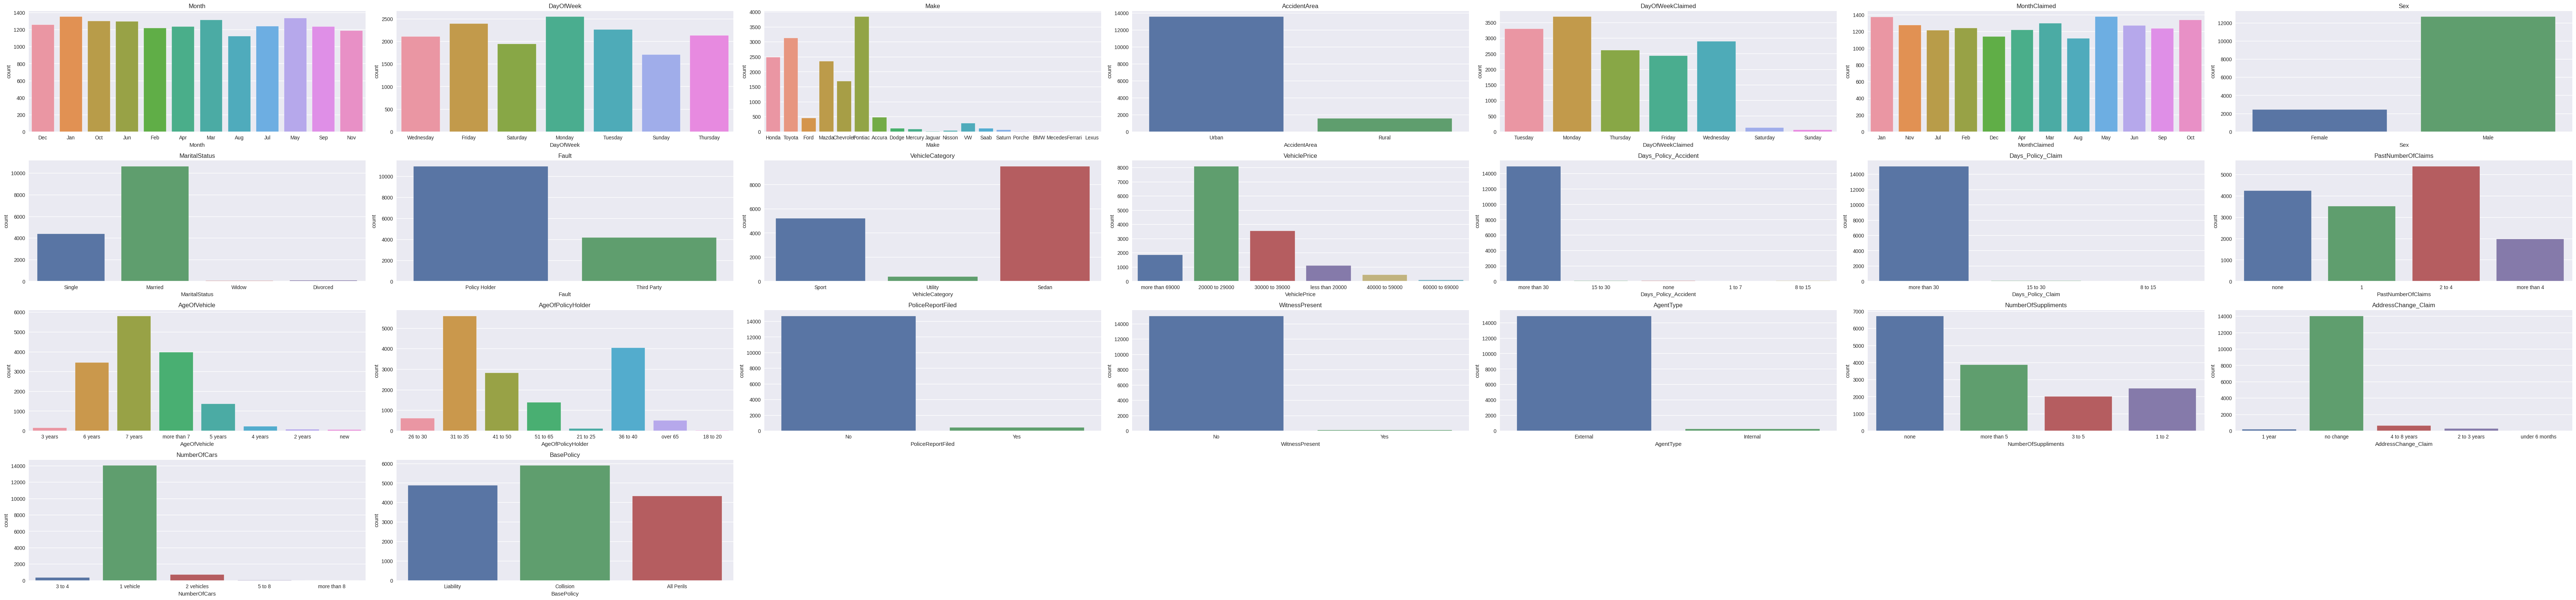

In [ ]:
""" Ahora haremos un analisis de las columnas categoricas en un grafico compuesto.
Lo que hacemos es un grafico de barras con un COUNT de cada una de las variables, a fin de ver si hay anomalias,
distribuciones extrañas, resultados llamativos """
plt.figure(figsize=(70, 20))
for i, col in enumerate(variables_categoricas):
    plt.subplot(5, 7, i+1)  # Ajusta el número de subplots según la cantidad de columnas
    sns.countplot(x=variables_categoricas[col])
    plt.title(col)

plt.tight_layout()
plt.show()

**Resultados iniciales de los graficos detallados arriba:**
-este es un analisis inicial, mas adelante en este notebook se entrara en detalle-

*Variables con cantidad de valores similares por atributo:*
* Month
* DayOfWeek
* MonthClaimed

Aqui podemos concluir que en lo que refiere a la distribucion de accidentes por mes del año y semana del mes, si bien hay dias y meses con mayor cantidad no es una diferencia significativa la encontrada.

*El resto de las variables en los graficos muestran cantidad de valores con mayores diferencias entre cada uno, debajo recopilamos las principales*

* Accident Area: se ve una mayor cantidad de accidentes en el area urbana.
* DayOfWeek : los fines de semana hay menos accidentes.
* Make: Se ve que algunas marcas de autos se repiten mas en los accidentes que otras, punto a analizar mas adelante.
* Sex: se ve una mayoria de hombres involucrados
* Marital Status: se ve una mayor cantidad de casados


### Correlacion de variables

Procederemos a analizar 3 correlaciones:

1.   Variables numericas con target
2.   Variables categoricas con target
3.   Variables categoricas entre si



#### Numericas vs target

En el analisis debajo se ve una correlacion baja para todas las variables numericas vs target con el objeto corrwith. No se ve ninguna correlacion fuerte.

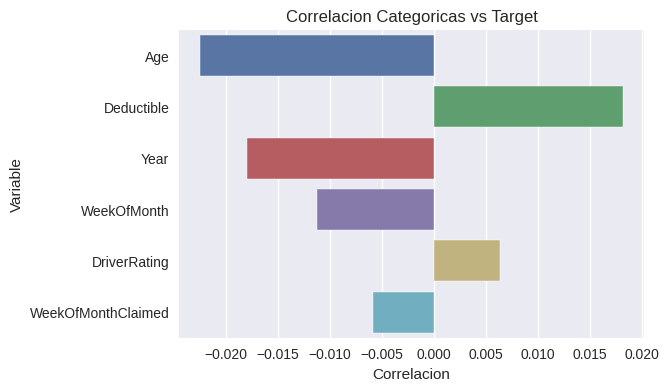

In [ ]:
# Calculo de la correlación entre las variables numéricas y FraudFound_P
correlation = df_insurance[variables_numericas.columns].corrwith(df_insurance['FraudFound_P'])

# Crear un DataFrame con los resultados
correlation_df = pd.DataFrame({'Variable': correlation.index, 'Correlation': correlation.values})

# Ordenar los resultados por valor absoluto de la correlación
correlation_df['Abs Correlation'] = correlation_df['Correlation'].abs()
correlation_df = correlation_df.sort_values(by='Abs Correlation', ascending=False)

# Visualizar la correlación en un gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x='Correlation', y='Variable', data=correlation_df, orient='h')
plt.title('Correlacion Categoricas vs Target')
plt.xlabel('Correlacion')
plt.ylabel('Variable')
plt.show()

#### Categoricas vs Target

Utilizaremos el metodo de chi cuadrado. El mismo sirve para trabajar con variables categoricas y su correlacion con un target. Lo que hace es calificar
con el chi score la importancia de cada variable respecto al target. tambien se puede usar como feature selector

En el codigo debajo se detallan los pasos tomados.

In [ ]:
# realizo codificación one-hot, para transformar las variables categoricas en una representacion numerica
encoder = OneHotEncoder()
encoded_categorical = encoder.fit_transform(variables_categoricas)

# aplico SelectKBest con chi2 (pero seleciono k=all, es decir usare todas las variables)
selector = SelectKBest(score_func=chi2, k='all')
selector.fit(encoded_categorical, df_insurance['FraudFound_P'])

# obtenemos las puntuaciones y los p-valores con la formula de chi2 de python.
chi2_scores = selector.scores_
chi2_pvalues = selector.pvalues_

# ajustamos el tamaño de las listas a la longitud de las columnas para no tener errores de formato.
num_features = len(variables_categoricas.columns)
chi2_scores = chi2_scores[:num_features]
chi2_pvalues = chi2_pvalues[:num_features]

#lo transformamos a un dataframe para luego poder graficarlo, y lo ordenamos de mayor correlacion a menor
results = pd.DataFrame({'Feature': variables_categoricas.columns, 'Score': chi2_scores, 'p-value': chi2_pvalues})
results = results.sort_values(by='Score', ascending=False)


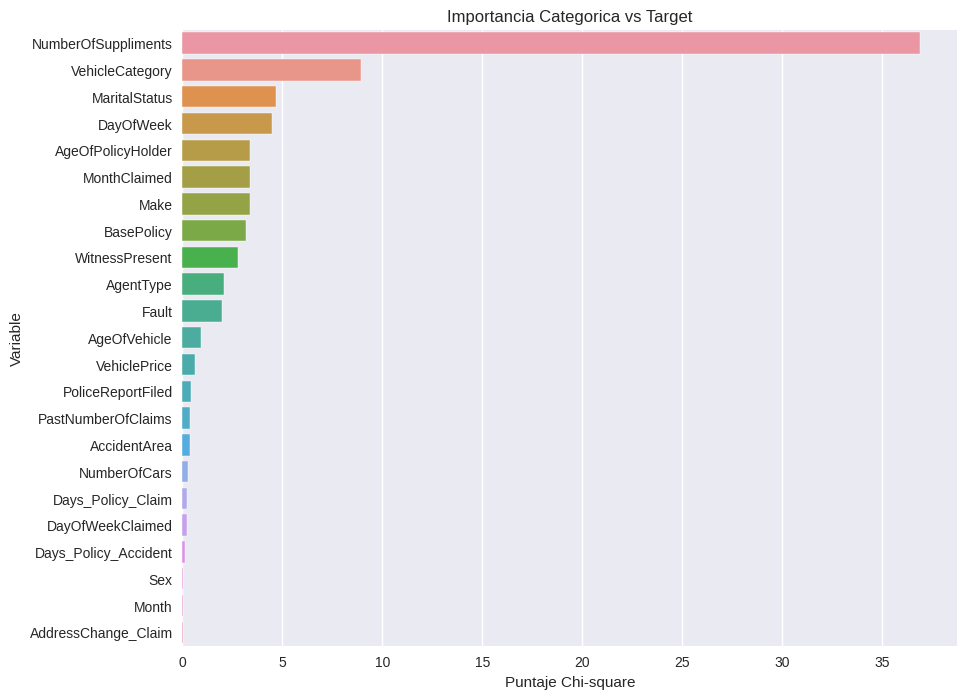

In [ ]:
# Ahora graficamos los resultados

plt.figure(figsize=(10, 8))
sns.barplot(x='Score', y='Feature', data=results, orient='h')
plt.title('Importancia Categorica vs Target')
plt.xlabel('Puntaje Chi-square')
plt.ylabel('Variable')
plt.show()

Podemos ver variables con correlaciones muy fuertes y otras con correlaciones muy bajas respecto a la variable target. Aguardaremos a aplicar el metodo de feature selection mas adelante para limpiar las variables a utilizar

#### Categoricas entre si

Utilizaremos un metodo llamado cramers V que permite comparar la relacion de  variables categoricas entre si

Podemos encontrar que hay variables fuertemente relacionada por su naturaleza ejemplo Month con MonthClaimed, pero mas alla de eso no se encuentran correlaciones realmente fuertes de +0.8 o -0.8


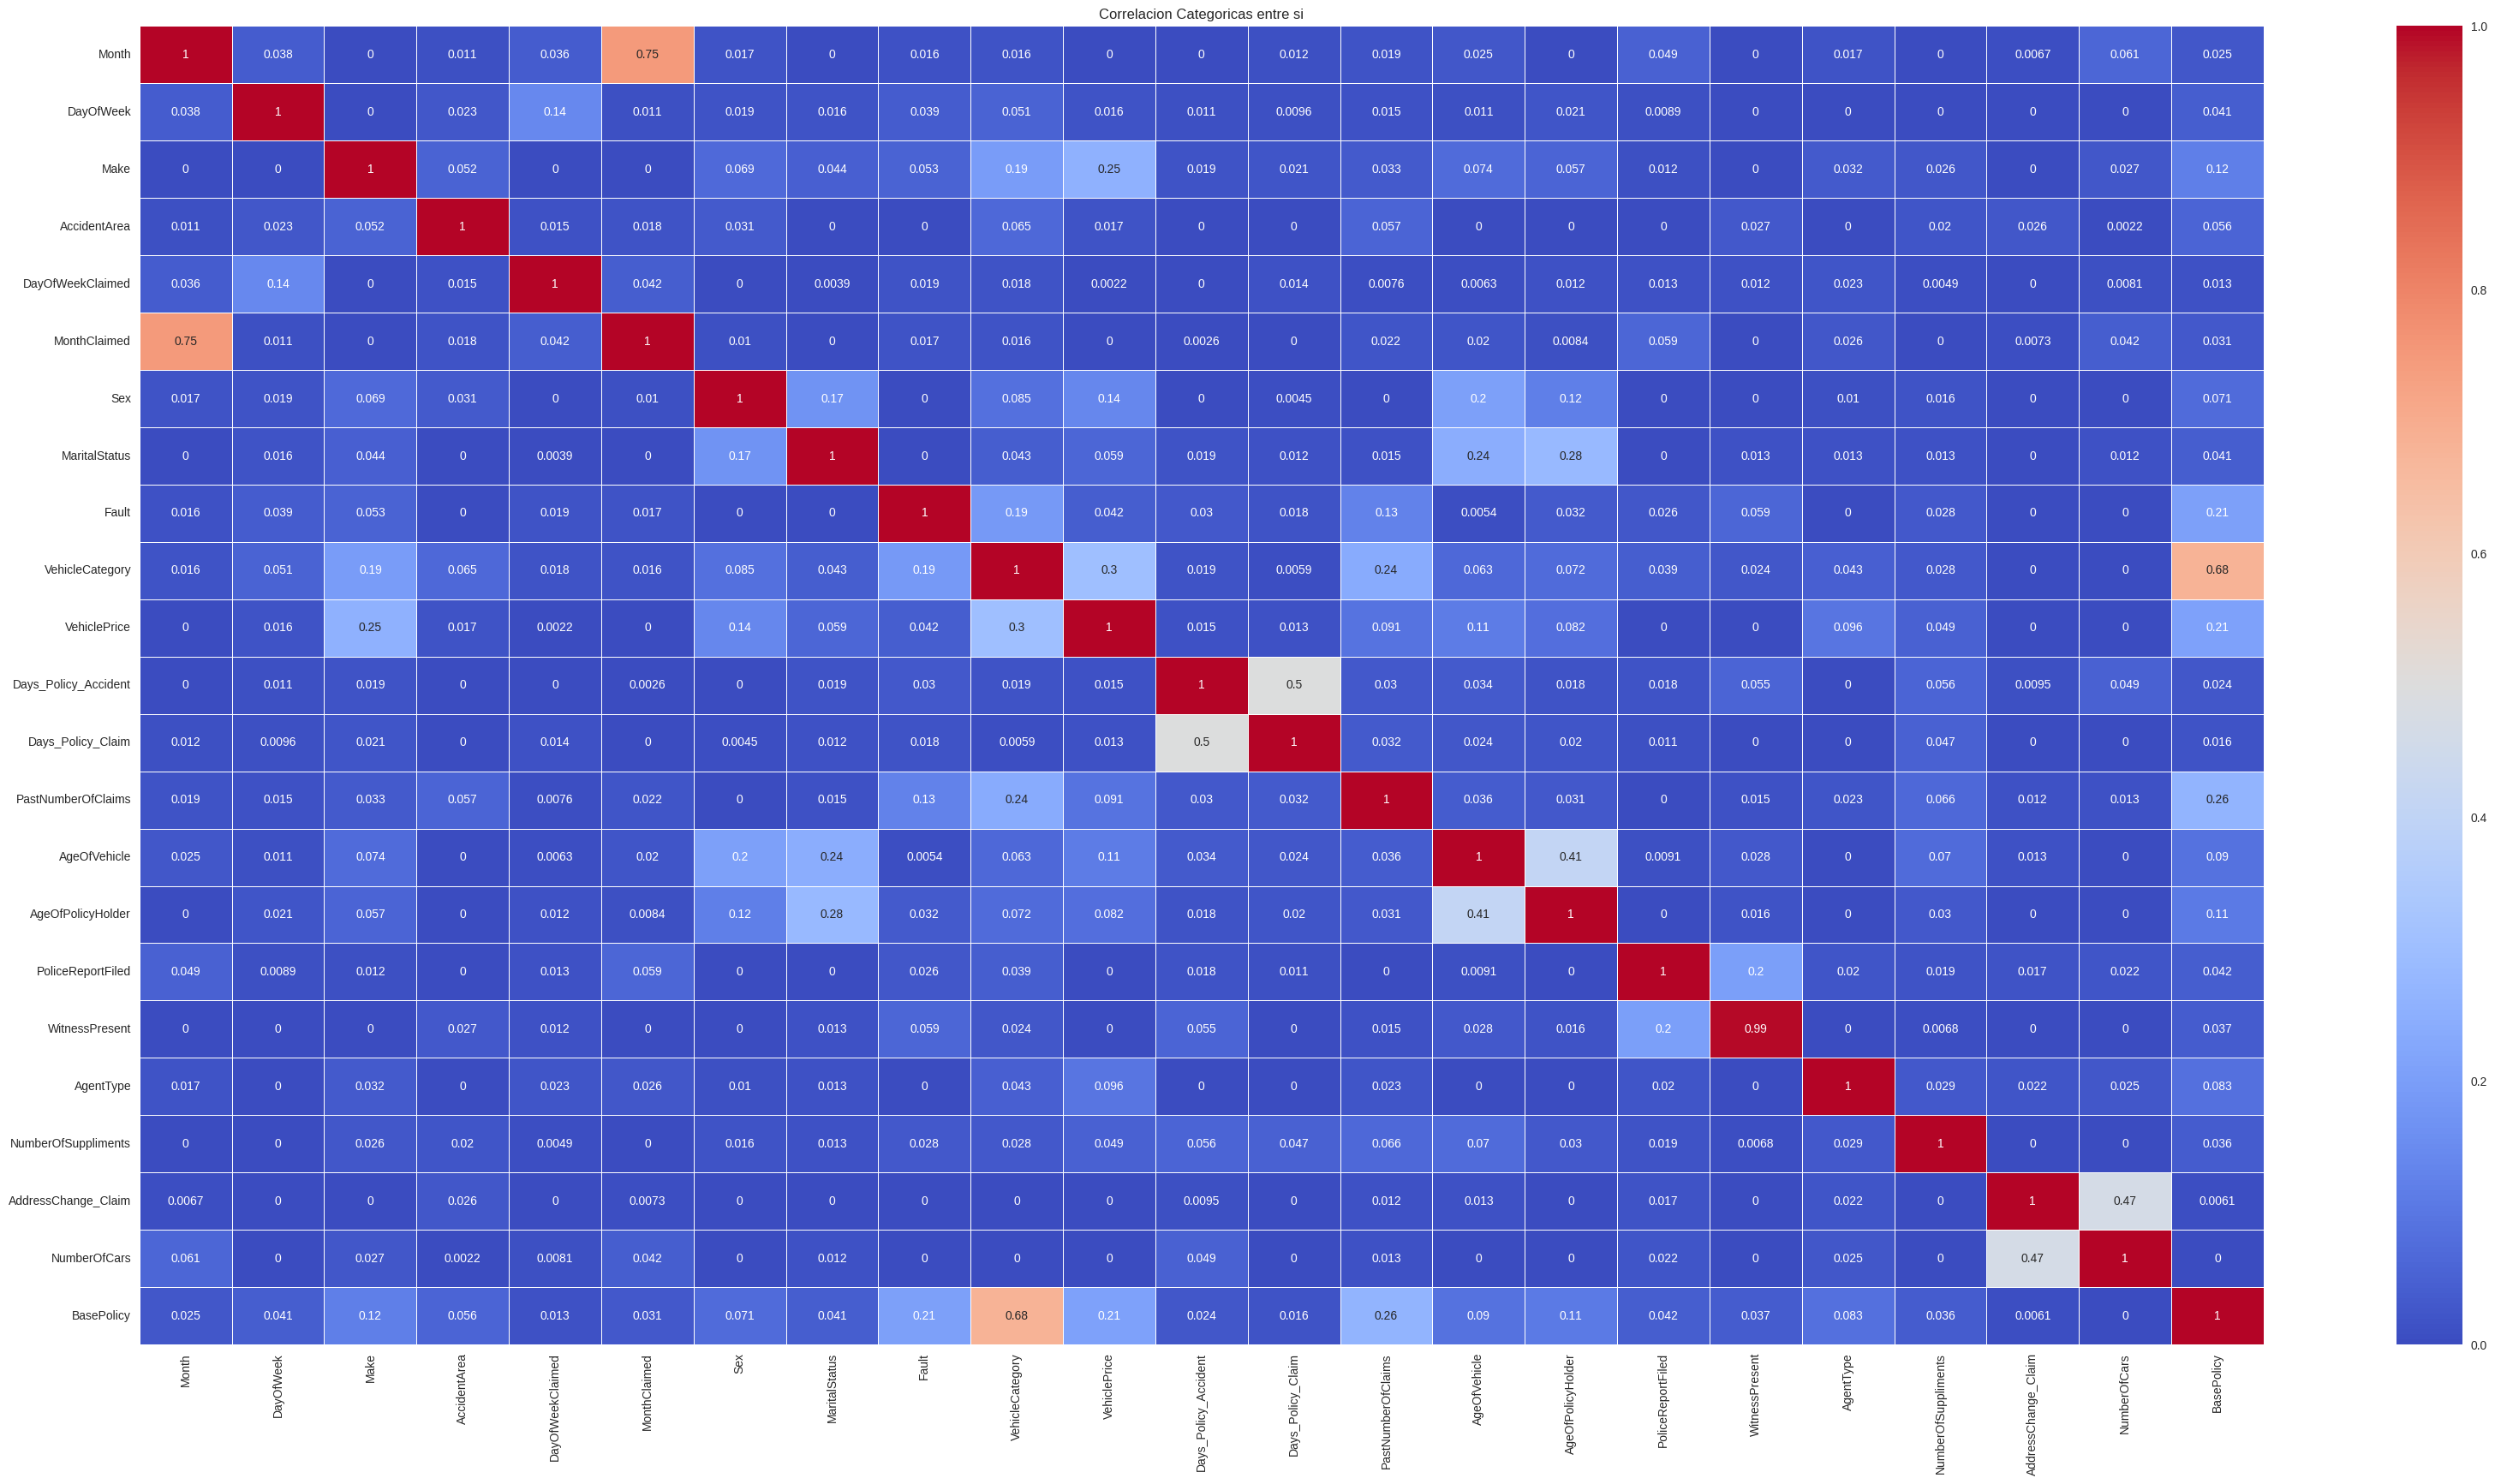

In [ ]:
#Función para calcular el coeficiente de Cramér's V
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calcular la matriz de correlación
correlation_matrix = pd.DataFrame(index=variables_categoricas.columns, columns=variables_categoricas.columns)

for col1 in variables_categoricas.columns:
    for col2 in variables_categoricas.columns:
        confusion_matrix = pd.crosstab(variables_categoricas[col1], variables_categoricas[col2])
        c_v = cramers_v(confusion_matrix)
        correlation_matrix.loc[col1, col2] = c_v

# Visualizar la matriz de correlación
plt.figure(figsize=(40, 20))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlacion Categoricas entre si')
plt.show()

## Preguntas y Visualizaciones

### Entender la proporcion de fraudes

Es importante entender primeramente, qué porcentaje de casos analizados por la aseguradora suelen ser fraudulentos, para entender el impacto financiero
y operativo que los mismos generan. Debajo concluimos que para la muestra tomada hay casi un 6% de casos con fraude.

In [ ]:
no_fraude = df_insurance[df_insurance.FraudFound_P == 0]
fraude = df_insurance[df_insurance.FraudFound_P == 1]

In [ ]:
fraud_counts = len(fraude)
non_fraud_counts = len(no_fraude)

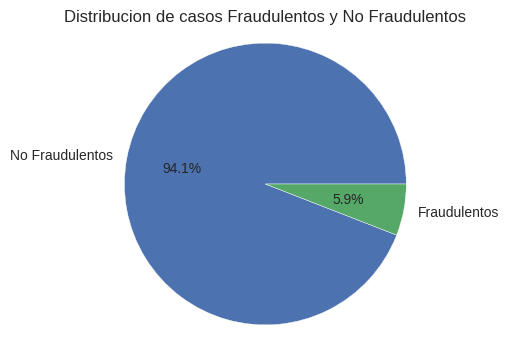

In [ ]:

labels = ['No Fraudulentos', 'Fraudulentos']
sizes = [non_fraud_counts, fraud_counts]

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels,autopct='%1.1f%%')
plt.title('Distribucion de casos Fraudulentos y No Fraudulentos')
plt.axis('equal')
plt.show()

Vemos un claro desbalance en la variable, por lo que mas adelante deberemos balancear la misma a fin de tener un modelo mas preciso.

### Caracteristicas de los asegurados

¿Cuál es la relacion entre la edad y la cantidad de accidentes, comparando los fraudulentos con los reales?

Hay una mayor proporcion de accidentes en las edades entre 31 y 40 años.

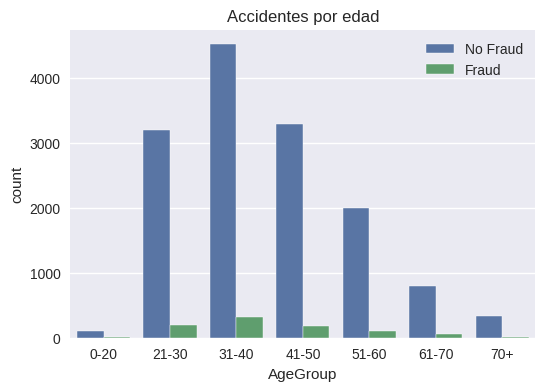

In [ ]:
# Defino intervalos de edad
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '70+']

# agrupo la edad en los intervalos definidos
df_insurance['AgeGroup'] = pd.cut(df_insurance['Age'], bins=bins, labels=labels)


plt.figure(figsize=(6, 4))
sns.countplot(x='AgeGroup', hue='FraudFound_P', data=df_insurance)
plt.legend(['No Fraud', 'Fraud'])
plt.title('Accidentes por edad')
plt.show()


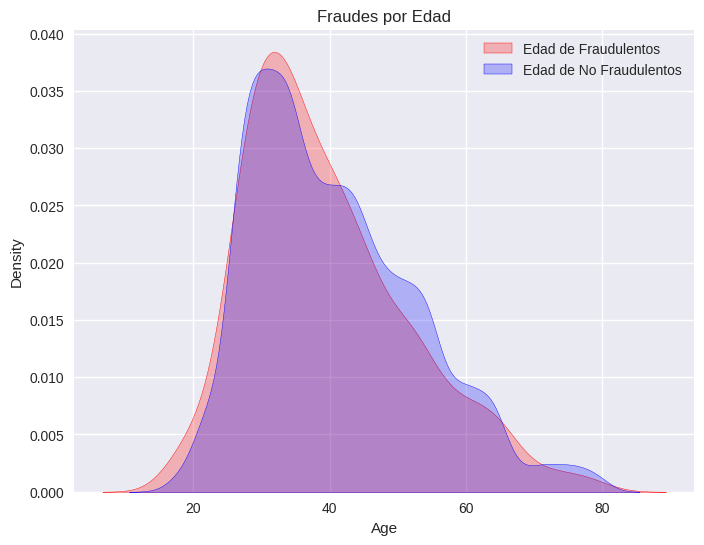

In [ ]:
plt.figure(figsize=(8,6))
sns.kdeplot(fraude['Age'], label='Edad de Fraudulentos', color='r', fill=True)
sns.kdeplot(no_fraude['Age'], label='Edad de No Fraudulentos', color='b', fill=True)
plt.title('Fraudes por Edad')
plt.legend()

In [ ]:
df_insurance = df_insurance.drop(columns='AgeGroup')


¿Hay alguna relación entre el género y estado marital del asegurado y la probabilidad de presentar reclamos fraudulentos?

La mayoria de los fraudes son ejecutados por hombres y el estado civil de los hombres que cometen fraude en su mayoría es CASADO.

Text(0.5, 0.98, 'Conteo accidentes segun Estado civil por Sexo y Fraude si/no')

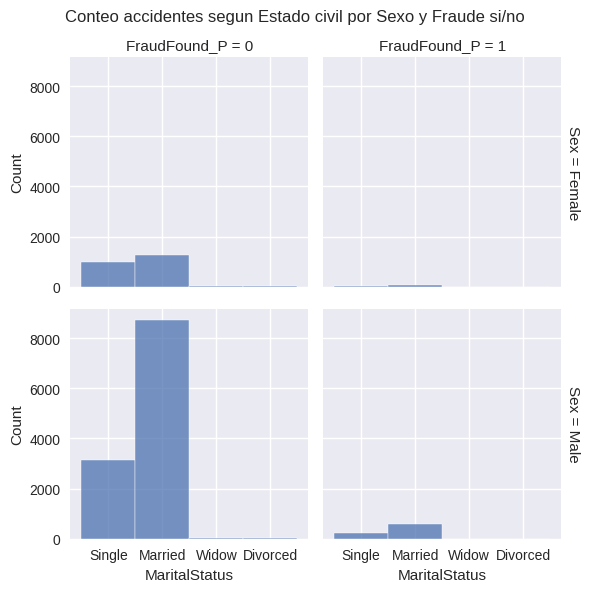

In [ ]:
grid = sns.FacetGrid(df_insurance, row='Sex', col='FraudFound_P', margin_titles=True)
grid.map(sns.histplot, 'MaritalStatus', bins=2)
plt.subplots_adjust(top=0.90)
grid.fig.suptitle('Conteo accidentes segun Estado civil por Sexo y Fraude si/no', fontsize=12)


In [ ]:
df_fraudes = df_insurance[df_insurance['FraudFound_P']==1]
fraude_por_genero = df_fraudes.groupby('Sex').size()
fraud_por_genero_porcentaje = fraude_por_genero / fraude_por_genero.sum() * 100

fraude_por_estadocivil = df_fraudes.groupby('MaritalStatus').size()
fraud_por_estadocivil_porcentaje = fraude_por_estadocivil / fraude_por_estadocivil.sum() * 100


Text(0.5, 1.0, 'Distribución de reclamos fraudulentos por Genero')

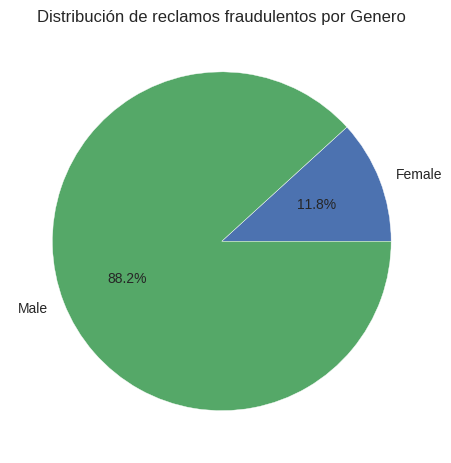

In [ ]:
plt.pie(fraud_por_genero_porcentaje, labels=['Female', 'Male'], autopct='%1.1f%%')
plt.title('Distribución de reclamos fraudulentos por Genero')

Text(0.5, 1.0, 'Estado civil de fraudulentos Masculinos')

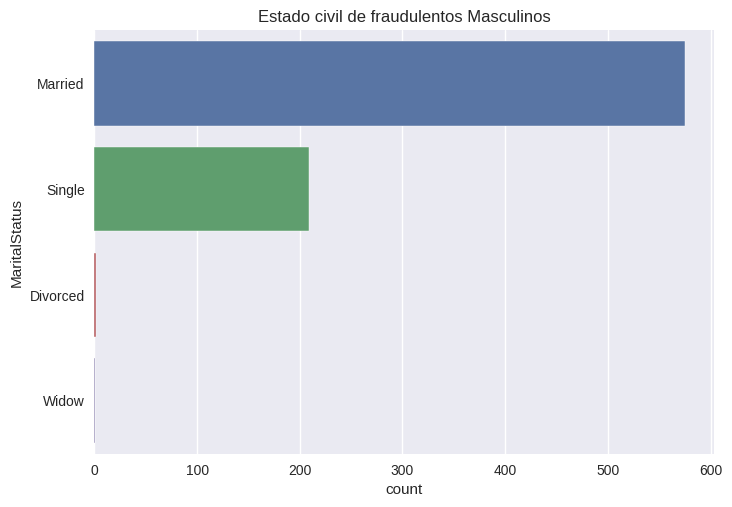

In [ ]:
filtrado = df_insurance[(df_insurance['FraudFound_P'] == 1) & (df_insurance['Sex'] == 'Male')]

sns.countplot(y='MaritalStatus', data=filtrado)
plt.title('Estado civil de fraudulentos Masculinos')

Text(0.5, 1.0, 'Estado civil de fraudulentos Femeninos')

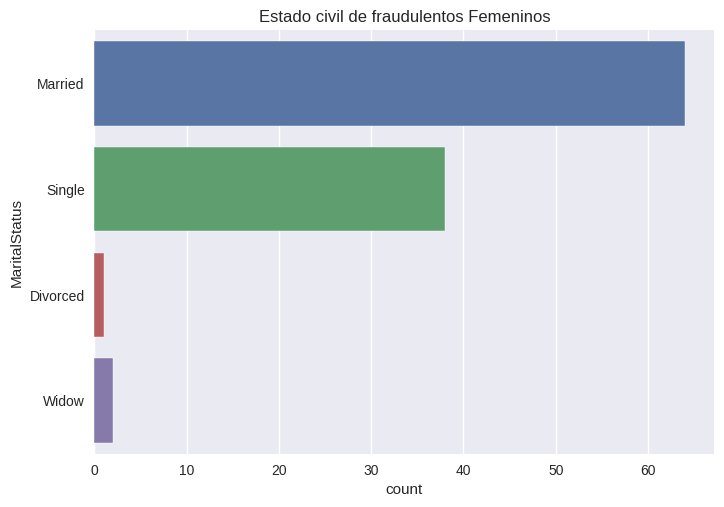

In [ ]:
filtrado2 = df_insurance[(df_insurance['FraudFound_P'] == 1) & (df_insurance['Sex'] == 'Female')]

sns.countplot(y='MaritalStatus', data=filtrado2)
plt.title('Estado civil de fraudulentos Femeninos')

¿Cuál es la relacion entre Genero y Estado Civil con el DriverRating?

La media del rating es 2 excepto para los hombres viudos que tienen un mejor rating, se podria analizar si esto tiene que ver con que sean mas adultos y con mas experiencia de manejo

Text(0.5, 1.0, 'Rating de los asegurados')

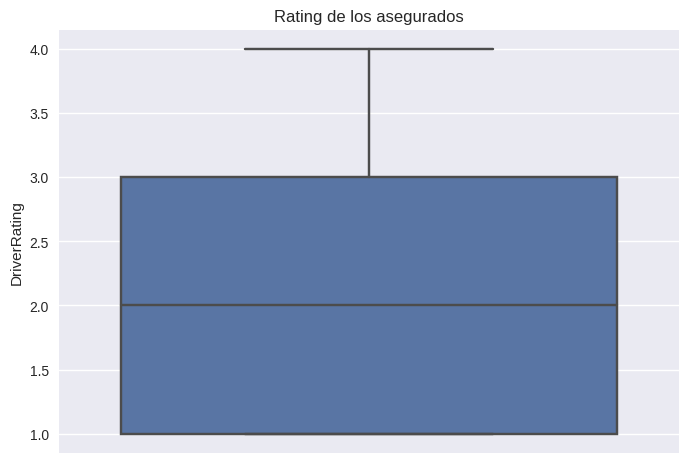

In [ ]:
sns.boxplot(y = 'DriverRating', data = df_insurance)
plt.title('Rating de los asegurados')

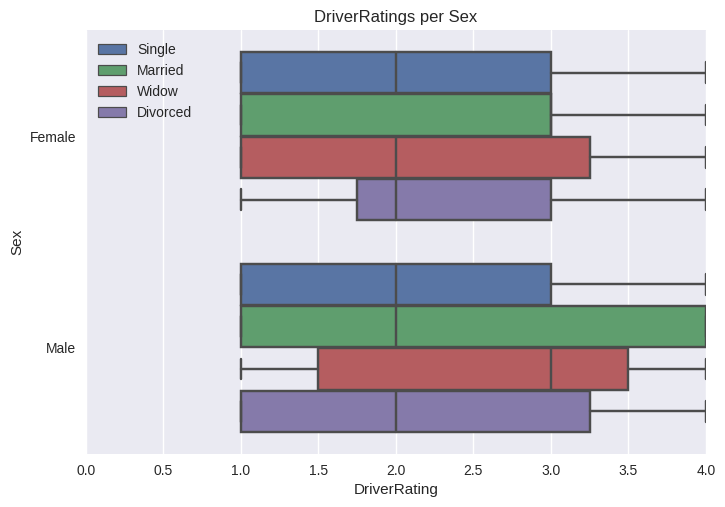

In [ ]:
sns.boxplot(y=df_insurance.Sex, x=df_insurance.DriverRating, hue=df_insurance.MaritalStatus, showfliers=True)
plt.xlim(0, df_insurance['DriverRating'].max())
plt.title('DriverRatings per Sex')
plt.legend(loc='best')

### Caracteristicas de los accidentes y reclamos

¿Existen patrones estacionales en la presentación de reclamos?

En el grafico debajo vemos que hay un pico maximo de casos en Enero (mes de invierno), y luego empiezan bajar nuevamente en febrero. Tambien vemos picos a la baja y a la alza el resto del año por lo que no podemos concluir si hay una relacion de causalidad real entre el clima y la cantidad de accidentes

In [ ]:
grouped_claims = df_insurance.groupby(['Month']).size().reset_index(name='Count')

In [ ]:
meses_ordenados = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_insurance['Month'] = pd.Categorical(df_insurance['Month'], categories=meses_ordenados, ordered=True)
grouped_claims = df_insurance.groupby('Month').size().reset_index(name='Count')
grouped_claims = grouped_claims.sort_values('Month')

In [ ]:
grouped_claims

,Month,Count
0,Jan,1352
1,Feb,1219
2,Mar,1313
3,Apr,1235
4,May,1336
5,Jun,1297
6,Jul,1241
7,Aug,1122
8,Sep,1235
9,Oct,1301


In [ ]:
mean_claims = np.mean(grouped_claims['Count'])

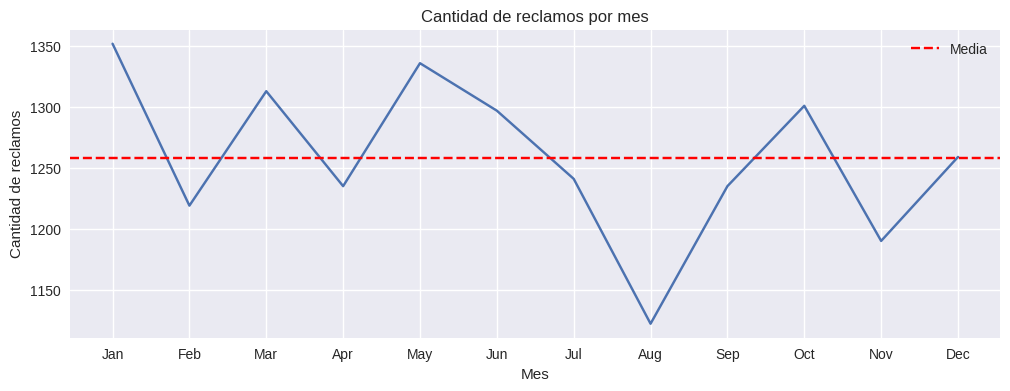

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(x='Month', y='Count', data=grouped_claims, linestyle='solid')
plt.title('Cantidad de reclamos por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de reclamos')
plt.axhline(y=grouped_claims['Count'].mean(), color='r', linestyle='--', label='Media')
plt.legend()
plt.show()


Hay mayor cantidad de accidentes en algun día o días específicos de la semana?

Se ve una leve disminucion de accidentes los fines de semana (sabado y domingo)


Text(0.5, 1.0, 'Accidentes por Día')

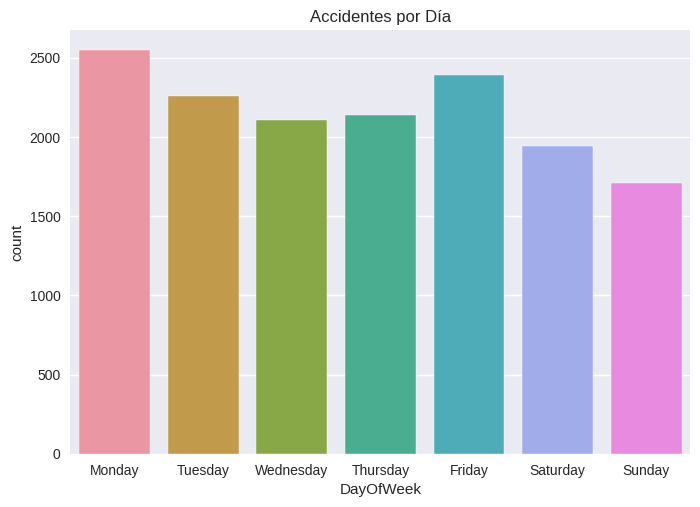

In [ ]:
orden=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(x=df_insurance['DayOfWeek'], order = orden)
plt.title('Accidentes por Día')

Proporcion de accidentes con peatones involucrados (se utiliza fuente de datos la API para contestar esta pregunta, recordar la misma es ajena al proyecto principal y se incluye a modo de ejemplo de uso de esta fuente de datos)

Hubo un 14% de casos de accidentes con peatones involucrados

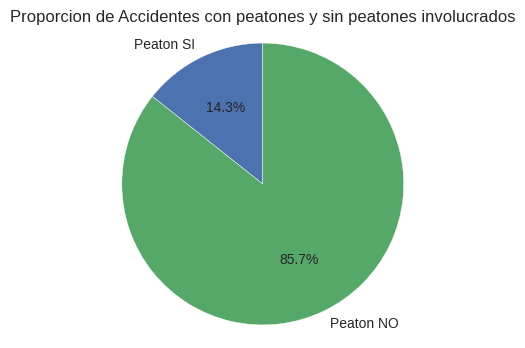

In [ ]:
pedestrian_fatalities = df_accidents['Peds'].sum()
non_pedestrian_fatalities = df_accidents['Fatals'].sum() - pedestrian_fatalities

labels = ['Peaton SI', 'Peaton NO']
sizes = [pedestrian_fatalities, non_pedestrian_fatalities]

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Proporcion de Accidentes con peatones y sin peatones involucrados')
plt.show()

¿El valor del vehículo asegurado influye en la probabilidad de presentar reclamos fraudulentos?

No se ve ninguna tendencia clara ni una fuerte correlacion entre el valor del vehiculo y los fraudes

In [ ]:
df_price_vs_fraud = df_insurance[['VehiclePrice', 'FraudFound_P']]

In [ ]:
grouped_price_vs_fraud = df_price_vs_fraud.groupby(['VehiclePrice', 'FraudFound_P']).size().reset_index(name='Count')
grouped_price_vs_fraud["VehiclePrice"] = grouped_price_vs_fraud["VehiclePrice"].astype("category")
grouped_price_vs_fraud["VehiclePrice"] = grouped_price_vs_fraud["VehiclePrice"].cat.reorder_categories(["less than 20000", "20000 to 29000", "30000 to 39000", "40000 to 59000", "60000 to 69000", "more than 69000"])

In [ ]:
grouped_price_vs_fraud

,VehiclePrice,FraudFound_P,Count
0,20000 to 29000,0,7658
1,20000 to 29000,1,421
2,30000 to 39000,0,3357
3,30000 to 39000,1,175
4,40000 to 59000,0,430
5,40000 to 59000,1,31
6,60000 to 69000,0,83
7,60000 to 69000,1,4
8,less than 20000,0,992
9,less than 20000,1,103


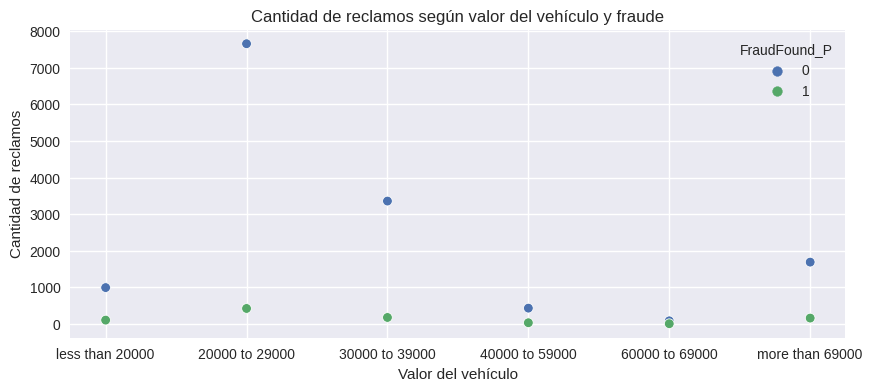

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.scatterplot(x="VehiclePrice", y="Count", hue="FraudFound_P", data=grouped_price_vs_fraud)
plt.title("Cantidad de reclamos según valor del vehículo y fraude")
plt.xlabel("Valor del vehículo")
plt.ylabel("Cantidad de reclamos")
plt.show()

Hay relacion entre la marca del vehiculo y la cantidad de accidentes?

Podemos observar los pontiac liderando la cantidd de accidentes.

Text(0, 0.5, 'Cantidad de accidentes')

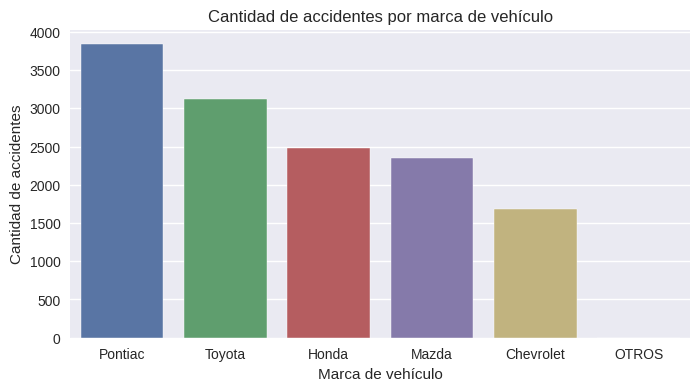

In [ ]:
## Grafico 4: Permite identificar los vehiculos mas propensos a presentar siniestros dentrodel dataframe. Esto ayudaria a evaluar riesgos a la hora de asegurar
plt.figure(figsize=(8,4))
car_counts = df_insurance['Make'].value_counts()
order = car_counts[car_counts >= 500].index.tolist()
order.append('OTROS')
sns.countplot(data=df_insurance, x='Make', order=order)
plt.title('Cantidad de accidentes por marca de vehículo')
plt.xlabel('Marca de vehículo')
plt.ylabel('Cantidad de accidentes')

Hay alguna tendencia con respecto al Area de los accidentes?

Se registra mayor cantidad de accidentes en el area Urbana.

Text(0.5, 1.0, 'Fraudes / AccidentArea')

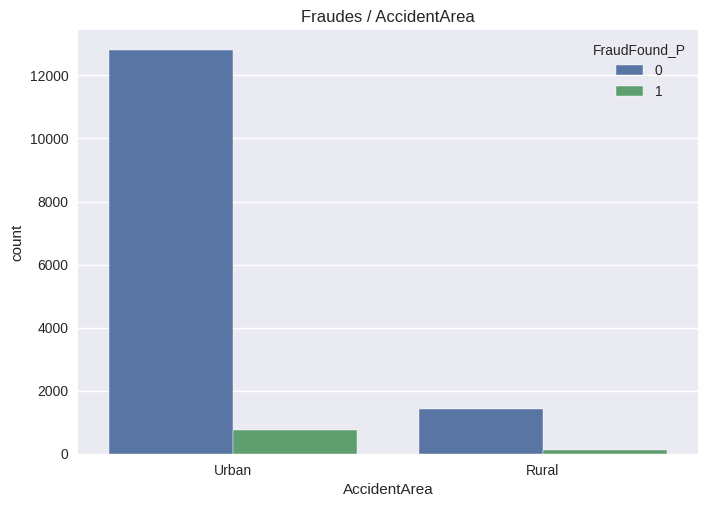

In [ ]:
sns.countplot(df_insurance,  x= 'AccidentArea', hue='FraudFound_P')
plt.title('Fraudes / AccidentArea')

Hay relacion entre los reclamos fraudulentos y la cantidad de accidentes/reclamos previos?

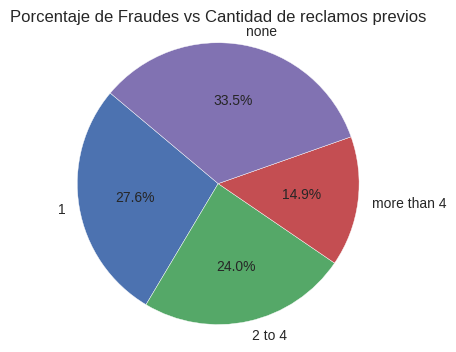

In [ ]:
# Crear un DataFrame que contenga solo las columnas relevantes
df_relacion = df_insurance[['PastNumberOfClaims', 'FraudFound_P']]

# Contar la cantidad total de casos para cada valor de "PastNumberOfClaims"
conteo_total = df_relacion['PastNumberOfClaims'].value_counts()

# Contar la cantidad de casos de fraude para cada valor de "PastNumberOfClaims"
conteo_fraude = df_relacion[df_relacion['FraudFound_P'] == 1]['PastNumberOfClaims'].value_counts()

# Calcular el porcentaje de fraude para cada valor de "PastNumberOfClaims"
porcentajes = (conteo_fraude / conteo_total) * 100

# Crear un gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(porcentajes, labels=porcentajes.index, autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Fraudes vs Cantidad de reclamos previos')
plt.axis('equal')
plt.show()

Podemos ver que de todos los casos de fraude, el 66,5% habia tenido reclamos anteriores. Una relacion interesante a tener en cuenta a la hora de buscar prevenir estos casos.

## Insights

•Casi el 6% de los casos fueron detectados como fraudulentos.

• Hay mayor cantidad de accidentes en el rango de 30-40 años.

•La mayoría de los fraudes son ejecutados por hombres y el estado civil de los hombres que cometen fraude en su mayoría es casado.

•La media del rating es 2 excepto para los hombres viudos que tienen un mejor rating, se podría analizar si esto tiene que ver con que sean mas adultos y con mas experiencia de manejo

•No hay pruebas de que haya incidencia directa en la cantidad de reclamos por la estación climática.

•Los dias de semana hay mayor cantidad de accidentes que los Sabados y Domingos

•No se encuentra relacion entre el valor del vehiculo y la probabilidad de presentar reclamos fraudulentos

•El mayor porcentaje de accidentes se da en el área Urbana, lo cual posiblemente tenga que ver con que hay mayor cantidad de autos y tránsito en la misma.

•Podemos ver que de todos los casos de fraude, el 66,5% habia tenido reclamos anteriores. Una relacion interesante a tener en cuenta a la hora de buscar prevenir estos casos.

## Feature Engeneering

En algunas partes previas de este trabajo podremos encontrar que ya se han estudiado y tambien seleccionado y transformado algunos de los atributos del Dataset original.

En el inicio hemos eliminado las columnas PolicyType, RepNumber y PolicyNumber.

Ademas ya hemos dividido los datos en 3 categorias: numericas, categoricas y target.

En la instancia del EDA se ha trabajado sobre los nulos, se ha definido que no hay duplicados y se ha decidido que los outliers seran mantenidos a fin de preservar la integridad de los datos y los resultados de los analisis sobre los mismos.

Ahora trabajaremos en algunos puntos mas sobre los datos y dejaremos definido el Dataset final sobre el cual se aplicará el modelo.

### Eliminacion de Features

In [ ]:
""" Retomando el ultimo punto del EDA donde analizamos la correlacion de las variables categoricas con el target a traves del metodo chi2,
se decide eliminar aquellas variables que demuestran menos importancia respecto al mismo a fin de ajustar un los datos para mejor estudio de los mismos.
Aqui hago una salvedad, mantendre en el dataset los siguientes 2: Sex y AccidentArea, mas alla de que el modelo de chi2 indique su poca incidencia
ya que me parece interesante que se mantengan en el modelo como datos clave relevantes de los usuarios."""

df_insurance = df_insurance.drop(['AddressChange_Claim', 'Month', 'Days_Policy_Accident', 'DayOfWeekClaimed', 'Days_Policy_Claim','WeekOfMonthClaimed'],axis=1)

### Encoding

In [ ]:
## Por la naturaleza de las informacion en el dataset,
##deberemos hacer manualmente una categorizacion de las siguientes columnas ordinales.
## lo que hacemos es a cada valor ponerle su valor ordinal (1,2,3,etc) y luego hacer el encoding.

encoding_ordinales = {
    'DayOfWeek': {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7},
    'MonthClaimed': {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12},
    'NumberOfSuppliments': {'none': 0, '1 to 2': 1, '3 to 5': 2, 'more than 5': 4},
    'PastNumberOfClaims': {'none': 0, '1': 1, '2 to 4':2, 'more than 4':3},
    'NumberOfCars':{'1 vehicle':1, '2 vehicles':2, '3 to 4':3, '5 to 8':4, 'more than 8':5},
    'AgeOfVehicle':{'new':0,'2 years':1, '3 years':2, '4 years':3, '5 years':4, '6 years':5, '7 years':6, 'more than 7':7},
    'AgeOfPolicyHolder': {'16 to 17': 1 , '18 to 20':2 , '21 to 25':3, '26 to 30':4, '31 to 35':5, '36 to 40':6, '41 to 50':7, '51 to 65':8, 'over 65':9 },
    'VehiclePrice':{ 'less than 20000':0,'20000 to 29000':1, '30000 to 39000':2, '40000 to 59000':3, '60000 to 69000':4, 'more than 69000':5}
}

for column, encoding_map in encoding_ordinales.items():
    df_insurance[column] = df_insurance[column].replace(encoding_map)
#en este ultimo loop lo que hacemos es reemplazar de acuerdo a lo detallado en encoding_ordinales, encoding map
#seria la informacion modificada.

In [ ]:
df_insurance.reset_index(drop=True, inplace=True)
df_insurance

,WeekOfMonth,DayOfWeek,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,VehicleCategory,...,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,NumberOfCars,Year,BasePolicy
0,5,3,Honda,Urban,1,Female,Single,21,Policy Holder,Sport,...,0,2,4,No,No,External,0,3,1994,Liability
1,3,3,Honda,Urban,1,Male,Single,34,Policy Holder,Sport,...,0,5,5,Yes,No,External,0,1,1994,Collision
2,5,5,Honda,Urban,11,Male,Married,47,Policy Holder,Sport,...,1,6,7,No,No,External,0,1,1994,Collision
3,2,6,Toyota,Rural,7,Male,Married,65,Third Party,Sport,...,1,7,8,Yes,No,External,4,1,1994,Liability
4,5,1,Honda,Urban,2,Female,Single,27,Third Party,Sport,...,0,4,5,No,No,External,0,1,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15095,4,5,Toyota,Urban,11,Male,Married,35,Policy Holder,Sedan,...,2,5,5,No,No,External,0,1,1996,Collision
15096,5,4,Pontiac,Urban,12,Male,Married,30,Policy Holder,Sport,...,3,5,5,No,No,External,4,3,1996,Liability
15097,5,4,Toyota,Rural,12,Male,Single,24,Policy Holder,Sedan,...,3,4,4,No,No,External,1,1,1996,Collision
15098,1,1,Toyota,Urban,12,Female,Married,34,Third Party,Sedan,...,0,1,5,No,No,External,4,1,1996,All Perils


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# aplicamos Label Encoder a las columnas categoricas no binarias ni ordinales (nominales)
columns_to_encode = ['Make','VehicleCategory', 'BasePolicy']
for column in columns_to_encode:
    df_insurance[column] = label_encoder.fit_transform(df_insurance[column])

In [ ]:
df_insurance.head()

,WeekOfMonth,DayOfWeek,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,VehicleCategory,...,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,NumberOfCars,Year,BasePolicy
0,5,3,6,Urban,1,Female,Single,21,Policy Holder,1,...,0,2,4,No,No,External,0,3,1994,2
1,3,3,6,Urban,1,Male,Single,34,Policy Holder,1,...,0,5,5,Yes,No,External,0,1,1994,1
2,5,5,6,Urban,11,Male,Married,47,Policy Holder,1,...,1,6,7,No,No,External,0,1,1994,1
3,2,6,17,Rural,7,Male,Married,65,Third Party,1,...,1,7,8,Yes,No,External,4,1,1994,2
4,5,1,6,Urban,2,Female,Single,27,Third Party,1,...,0,4,5,No,No,External,0,1,1994,1


In [ ]:
#Aplicamos OHE(Dummies) a las columnas categoricas Binarias.

df_insurance = pd.get_dummies(df_insurance, columns = ['AccidentArea', 'Sex', 'MaritalStatus', 'Fault', 'PoliceReportFiled','WitnessPresent','AgentType'])


In [ ]:
#asi nos quedaria ya el dataset con el encoding aplicado a todas las columnas
#menos a las numericas (age y deductible) que no lo requieren
df_insurance

,WeekOfMonth,DayOfWeek,Make,MonthClaimed,Age,VehicleCategory,VehiclePrice,FraudFound_P,Deductible,DriverRating,...,MaritalStatus_Single,MaritalStatus_Widow,Fault_Policy Holder,Fault_Third Party,PoliceReportFiled_No,PoliceReportFiled_Yes,WitnessPresent_No,WitnessPresent_Yes,AgentType_External,AgentType_Internal
0,5,3,6,1,21,1,5,0,300,1,...,1,0,1,0,1,0,1,0,1,0
1,3,3,6,1,34,1,5,0,400,4,...,1,0,1,0,0,1,1,0,1,0
2,5,5,6,11,47,1,5,0,400,3,...,0,0,1,0,1,0,1,0,1,0
3,2,6,17,7,65,1,1,0,400,2,...,0,0,0,1,0,1,1,0,1,0
4,5,1,6,2,27,1,5,0,400,1,...,1,0,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15095,4,5,17,11,35,0,1,1,400,4,...,0,0,1,0,1,0,1,0,1,0
15096,5,4,13,12,30,1,2,0,400,3,...,0,0,1,0,1,0,1,0,1,0
15097,5,4,17,12,24,0,1,1,400,4,...,1,0,1,0,1,0,1,0,1,0
15098,1,1,17,12,34,0,1,0,400,4,...,0,0,0,1,1,0,1,0,1,0


### Feature Selection



In [ ]:
#Separamos entre variables independientes y variable dependiente

X =df_insurance.drop(columns=['FraudFound_P'])
y=df_insurance['FraudFound_P']

In [ ]:
#separamos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#estandarizamos las escalas
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
X_train

array([[ 1.52459404, -0.73580664, -0.09905801, ...,  0.68815322,
        -1.70910999, -0.23880472],
       [-0.74622745,  1.56646668, -1.65822553, ..., -0.25169388,
        -0.34443969, -0.84400933],
       [-3.75151443, -0.18224021, -0.35466051, ...,  1.68545711,
         2.45125832, -0.30487689],
       ...,
       [-0.16157071,  0.22249175, -0.59319773, ...,  1.74830836,
        -1.18886854, -0.27477535],
       [-2.00517529, -0.2358622 , -0.22171676, ...,  0.67817394,
         0.70002534,  0.26701498],
       [ 1.60546415,  0.93742668, -0.89623397, ...,  0.90169861,
         1.09790995,  0.25981102]])

In [ ]:
X_test

array([[ 1.06372671, -1.61227446,  0.9936608 , ..., -0.69635934,
         1.54527092,  0.08240226],
       [-0.90215626,  0.37739358, -0.7982616 , ...,  1.98659736,
        -0.73052841,  0.27679521],
       [ 2.19017677,  0.27695225, -0.4588841 , ..., -1.87573111,
         0.57104061, -0.5552123 ],
       ...,
       [ 3.25170692, -1.7748695 ,  0.87256484, ..., -0.76167664,
         0.51570631,  1.03873859],
       [ 1.19073852,  0.35902351, -0.91845065, ...,  2.16737861,
        -1.62688208, -0.80395184],
       [ 3.27518589,  1.76958018, -1.97748563, ..., -0.34921738,
         0.47239054,  0.32947849]])

In [ ]:
# Explicación de la varianza de las componentes
explained_variance = pca.explained_variance_ratio_
explained_variance

#El primer componente explica el 0.10% de la variabilidad de mis datos y el segundo el 0.08%,
# Es decir que la varianza evidentemente esta muy distribuida entre todos los componentes.

array([0.10664876, 0.07950743, 0.07181181, 0.06408455, 0.06234338,
       0.05893502, 0.05142552, 0.04780222, 0.0389881 , 0.03690304])

## Modelos

El objetivo, como indicado al inicio de este trabajo, es la prediccion de casos de fraude. Es por eso que podemos decir que tenemos un problema de clasificacion binaria, donde 0 seria sin fraude y 1 seria con fraude.

Un punto a tener en cuenta es que en el EDA pudimos determinar que en nuesto Dataset, la variable Fraude esta desbalanceada. Por esto, primero haremos las pruebas de modelos sin aplicar ningun balanceo sobre esta variable y luego lo haremos con el metodo SMOTE para oversampling. En base a esto compararemos los resultados obtenidos.

Trabajaremos sobre los siguientes modelos que consideramos ajustables al problema presentado: Regresion Logistica, KNN, Decision Tree Classifier y Random Forest Classifier.

In [ ]:
# Modelos Vacios:

LR = LogisticRegression(max_iter=15100)
KNN = KNeighborsClassifier()
DTC = DecisionTreeClassifier(random_state = 42)
RFC = RandomForestClassifier(random_state = 42)

models = [LR,KNN,DTC,RFC]

In [ ]:
# para evaluar los resultados analizaremos las siguientes metricas en conjunto, y el promedio de las mismas como score general.
metrics = {
    'Accuracy': accuracy_score,
    'F1 Score': f1_score,
    'ROC AUC': roc_auc_score,
}

### Cross Validation pre balanceo

In [ ]:
results_imbalanced = []

for model in models:
    model_name = model.__class__.__name__

    # crea un DataFrame para cada modelo
    model_df = pd.DataFrame(columns=["Modelo"] + list(metrics.keys()) + ['Average Score'])

    # inicializa variables para hacer seguimiento del mejor pliegue
    best_fold_index = None
    best_average_score = float('-inf')

    # realiza validación cruzada en los datos resampleados
    for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(X, y)):
        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)  # entrena el modelo en el conjunto de entrenamiento del pliegue
        y_pred = model.predict(X_val_fold)      # realiza las predicciones en el conjunto de validación del pliegue

        fold_metrics = {}  # almacena métricas por pliegue
        for metric_name, metric_func in metrics.items():
            score = metric_func(y_val_fold, y_pred)
            fold_metrics[metric_name] = score

        # calcula el puntaje promedio entre las métricas
        average_score = np.mean(list(fold_metrics.values()))

        # crea un DataFrame temporal para el pliegue actual
        fold_df = pd.DataFrame({"Modelo": model_name, **fold_metrics, 'Average Score': average_score}, index=[0])

        # concatena el DataFrame del pliegue con el DataFrame del modelo
        model_df = pd.concat([model_df, fold_df], ignore_index=True)

        # actualiza el mejor pliegue si el puntaje promedio es más alto
        if average_score > best_average_score:
            best_average_score = average_score
            best_fold_index = fold

    results_imbalanced.append(model_df)

# concatena todos los DataFrames en uno solo
results_imbalanced = pd.concat(results_imbalanced, ignore_index=True)

# imprime el DataFrame en forma de tabla
print("Resultados pre-balanceo:")
print(results_imbalanced.to_string(index=False))

Resultados pre-balanceo:
                Modelo  Accuracy  F1 Score  ROC AUC  Average Score
    LogisticRegression  0.940066  0.000000 0.500000       0.480022
    LogisticRegression  0.940728  0.000000 0.500000       0.480243
    LogisticRegression  0.941391  0.000000 0.500000       0.480464
    LogisticRegression  0.942715  0.000000 0.500000       0.480905
    LogisticRegression  0.939735  0.000000 0.500000       0.479912
  KNeighborsClassifier  0.939073  0.051546 0.512403       0.501007
  KNeighborsClassifier  0.939404  0.041885 0.509765       0.497018
  KNeighborsClassifier  0.937417  0.010471 0.500539       0.482809
  KNeighborsClassifier  0.941391  0.063492 0.515585       0.506823
  KNeighborsClassifier  0.935430  0.010152 0.500281       0.481954
DecisionTreeClassifier  0.898675  0.211340 0.584024       0.564680
DecisionTreeClassifier  0.894371  0.188295 0.572201       0.551622
DecisionTreeClassifier  0.895364  0.189744 0.573567       0.552891
DecisionTreeClassifier  0.885430  0.1

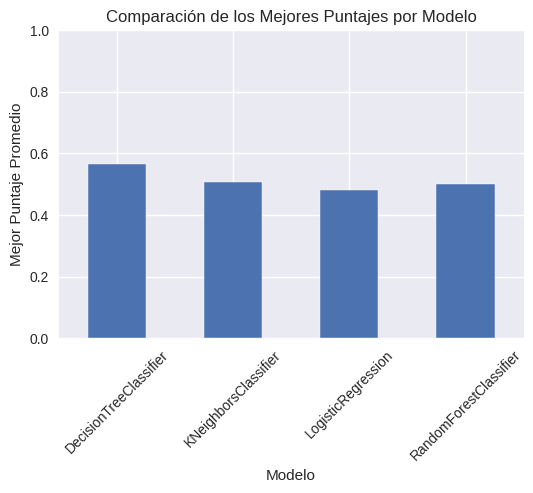

In [ ]:
# Crear la figura y los ejes
plt.figure(figsize=(6, 4))
ax = best_scores_imbalanced.plot(kind='bar')

# Configura el título y etiquetas de los ejes
plt.title('Comparación de los Mejores Puntajes por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Mejor Puntaje Promedio')
plt.xticks(rotation=45)

# Establece el valor máximo del eje y en 1
ax.set_ylim(0, 1)

plt.show()

Todos los modelos se ven ampliamente afectados por la variable target desbalanceada.
En el caso del accuracy, la misma se ve muy afectada cuando trabajamos con variables desbalanceadas por lo que no la tendremos en cuenta como variable principal. Si vemos el detalle, si nos basaramos solo en la misma podriamos creer que tenemos modelos buenos, cuando la realidad es otra.
Vemos que en todos los modelos el ROC/AUC da al rededor de 0.5, lo que nos indica que basicamente se esta prediciendo de manera azaroza.
Ademas, el F1 score nos da siempre 0 o casi 0, reflejo de los malos resultados en precision y recall.

### Blanceo de Variable

In [ ]:
oversampler = SMOTE(sampling_strategy=0.55)
X_resampled, y_resampled = oversampler.fit_resample(X, y)
print('After Oversampling:\n',y_resampled.value_counts())

After Oversampling:
 0    14208
1     7814
Name: FraudFound_P, dtype: int64


### Cross Validation post balanceo

In [ ]:
results_balanced = []

for model in models:
    model_name = model.__class__.__name__

    # crea un DataFrame para cada modelo
    model_df = pd.DataFrame(columns=["Modelo"] + list(metrics.keys()) + ['Average Score'])

    # inicializa variables para hacer seguimiento del mejor pliegue
    best_fold_index = None
    best_average_score = float('-inf')

    # realiza validación cruzada en los datos resampleados
    for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(X_resampled, y_resampled)):
        X_train_fold, y_train_fold = X_resampled.iloc[train_idx], y_resampled.iloc[train_idx]
        X_val_fold, y_val_fold = X_resampled.iloc[val_idx], y_resampled.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)  # entrena el modelo en el conjunto de entrenamiento del pliegue
        y_pred = model.predict(X_val_fold)      # realiza predicciones en el conjunto de validación del pliegue

        fold_metrics = {}  # almacena métricas por pliegue
        for metric_name, metric_func in metrics.items():
            score = metric_func(y_val_fold, y_pred)
            fold_metrics[metric_name] = score

        # calcula el puntaje promedio entre las métricas
        average_score = np.mean(list(fold_metrics.values()))

        # crea un DataFrame temporal para el pliegue actual
        fold_df = pd.DataFrame({"Modelo": model_name, **fold_metrics, 'Average Score': average_score}, index=[0])

        # concatena el DataFrame del pliegue con el DataFrame del modelo
        model_df = pd.concat([model_df, fold_df], ignore_index=True)

        # actualiza el mejor pliegue si el puntaje promedio es más alto
        if average_score > best_average_score:
            best_average_score = average_score
            best_fold_index = fold

    results_balanced.append(model_df)

# concatena todos los DataFrames en uno solo
results_balanced = pd.concat(results_balanced, ignore_index=True)

# imprime el DataFrame en forma de tabla
print("Resultados post-balanceo:")
print(results_balanced.to_string(index=False))

Resultados post-balanceo:
                Modelo  Accuracy  F1 Score  ROC AUC  Average Score
    LogisticRegression  0.864245  0.797151 0.840830       0.834075
    LogisticRegression  0.857662  0.790090 0.831917       0.826556
    LogisticRegression  0.864668  0.791170 0.835029       0.830289
    LogisticRegression  0.858311  0.788618 0.833385       0.826771
    LogisticRegression  0.856267  0.787798 0.830762       0.824942
  KNeighborsClassifier  0.860386  0.833288 0.892220       0.861965
  KNeighborsClassifier  0.869012  0.845350 0.894225       0.869529
  KNeighborsClassifier  0.863306  0.834888 0.894045       0.864080
  KNeighborsClassifier  0.853996  0.827937 0.885985       0.855973
  KNeighborsClassifier  0.864214  0.840873 0.892378       0.865822
DecisionTreeClassifier  0.911237  0.877698 0.911191       0.900042
DecisionTreeClassifier  0.905108  0.871936 0.901844       0.892963
DecisionTreeClassifier  0.917575  0.884652 0.915758       0.905995
DecisionTreeClassifier  0.903270  0.

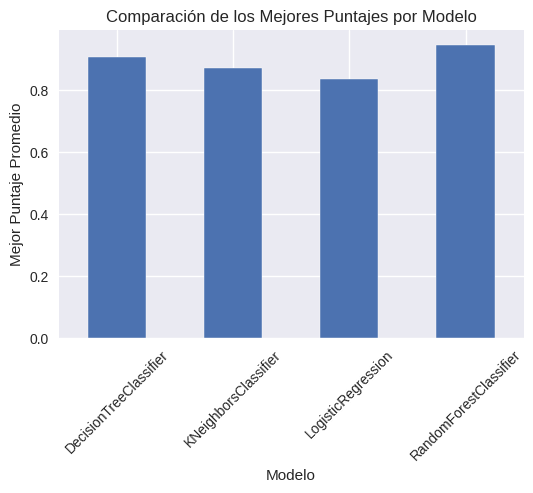

In [ ]:
# mejores puntajes de cada modelo
best_scores_balanced = results_balanced.groupby('Modelo')['Average Score'].max()

# Gráfica comparativa
plt.figure(figsize=(6, 4))
best_scores_balanced.plot(kind='bar')
plt.title('Comparación de los Mejores Puntajes por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Mejor Puntaje Promedio')
plt.xticks(rotation=45)
ax.set_ylim(0, 1)
plt.show()

Podemos observar como el balanceo del target nos ayuda a entrenar y generar modelos ampliamente mejorados. Si bien obtenemos los mejores resultados en el Random Forest, todos los modelos tuvieron una gran mejora que los llevo a ser viables para trabajar con ellos.
Vemos en todos un mayor equilibrio en los resultados del accuracy, del f1-score (lo que implica que tenemos un mejor recall y precision) y mediante el ROC-AUC podemos determinar que no estariamos trabajando de manera azaroza sino que realmente estamos obteniendo esos resultados.

### Comparacion resultados

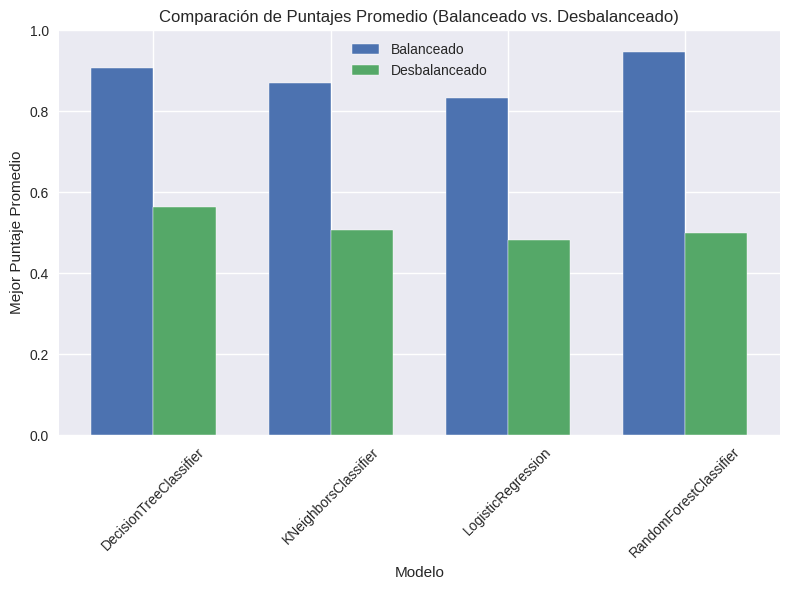

In [ ]:
model_names = best_scores_balanced.index
scores_balanced = best_scores_balanced.values
scores_imbalanced = best_scores_imbalanced.values

# Configuración de la gráfica
width = 0.35  # Ancho de las barras
x = np.arange(len(model_names))

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Dibuja las barras
ax.bar(x - width/2, scores_balanced, width, label='Balanceado')
ax.bar(x + width/2, scores_imbalanced, width, label='Desbalanceado')

# Configura el título y etiquetas de los ejes
ax.set_title('Comparación de Puntajes Promedio (Balanceado vs. Desbalanceado)')
ax.set_xlabel('Modelo')
ax.set_ylabel('Mejor Puntaje Promedio')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylim(0, 1)
ax.legend()

# Muestra el gráfico
plt.tight_layout()
plt.show()


In [ ]:
improvement_percentage = [(b - ib) / ib * 100 for b, ib in zip(scores_balanced, scores_imbalanced)]
improvement_df = pd.DataFrame({"Modelo": model_names, "Mejora": improvement_percentage})

print(improvement_df)

                   Modelo     Mejora
0  DecisionTreeClassifier  60.443988
1    KNeighborsClassifier  71.564836
2      LogisticRegression  73.438670
3  RandomForestClassifier  89.452354


Como mencionado anteriormente, vemos amplias mejoras en scores promedio de los modelos, en detalle arriba tenemos los % de mejora gracias al balanceo.

## Hypertuning

Probaremos con el metodo de Randomized Search para encontrar los mejores parametros de cada modelo y sacar las conclusiones finales.
Primero haremos el hypertuning de cada uno, luego los entrenaremos con los parametros obtenidos y veremos los resultados en comparativa.

### Logistic Regression

In [ ]:
# parametros:
param_dist_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Valores para el hiperparámetro de regularización
    'max_iter': [100, 2000, 5000, 15100],        # Número máximo de iteraciones
    }

# Realiza la búsqueda aleatoria
random_search_LR = RandomizedSearchCV(LR, param_distributions=param_dist_LR, n_iter=10, scoring='f1', cv=5, n_jobs=-1, random_state=42)

# Ajusta el modelo a tus datos
random_search_LR.fit(X_resampled, y_resampled)

best_params_LR = random_search_LR.best_params_

# Muestra los mejores hiperparámetros
print("Mejores hiperparámetros para Logistic Regression :")
print(best_params_LR)



Mejores hiperparámetros para Logistic Regression :
{'max_iter': 15100, 'C': 1}


### KNN

In [ ]:
param_dist_KNN = {
    'n_neighbors': [3, 5, 7, 9,12],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Peso de los vecinos
    'p': [1, 2],  # Parámetro p para la distancia (1 para distancia de Manhattan, 2 para distancia euclidiana)
    'leaf_size' :[10,30,50,100]
}

# Crea una instancia de K-Nearest Neighbors
KNN = KNeighborsClassifier()

# Realiza la búsqueda aleatoria
random_search_KNN = RandomizedSearchCV(KNN, param_distributions=param_dist_KNN, n_iter=10, scoring='f1', cv=5, n_jobs=-1, random_state=42)

# Ajusta el modelo a tus datos
random_search_KNN.fit(X_resampled, y_resampled)

best_params_KNN = random_search_KNN.best_params_

# Muestra los mejores hiperparámetros
print("Mejores hiperparámetros para K-Nearest Neighbors:")
print(best_params_KNN)

Mejores hiperparámetros para K-Nearest Neighbors:
{'weights': 'uniform', 'p': 1, 'n_neighbors': 3, 'leaf_size': 10}


### Decision Tree Classifier

In [ ]:
# parametros:
param_dist_DTC = {
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],           # Mínimo de muestras para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]              # Mínimo de muestras requeridas en un nodo hoja
}

# Crea una instancia de Decision Tree Classifier
DTC = DecisionTreeClassifier(random_state=42)

# Realiza la búsqueda aleatoria
random_search_DTC = RandomizedSearchCV(DTC, param_distributions=param_dist_DTC, n_iter=10, scoring='f1', cv=5, n_jobs=-1, random_state=42)

# Ajusta el modelo a tus datos
random_search_DTC.fit(X_resampled, y_resampled)

best_params_DTC = random_search_DTC.best_params_

# Muestra los mejores hiperparámetros
print("Mejores hiperparámetros para Decision Tree Classifier:")
print(best_params_DTC)

Mejores hiperparámetros para Decision Tree Classifier:
{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 50}


### Random Forest Classifier

In [ ]:
# parametros:
param_dist_RF = {
    'n_estimators': [50, 100, 200],           # Número de árboles en el bosque
    'criterion':['gini','entropy','log_loss'],
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],           # Mínimo de muestras para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]              # Mínimo de muestras requeridas en un nodo hoja
}

# Crea una instancia de Random Forest Classifier
RFC = RandomForestClassifier(random_state=42)

# Realiza la búsqueda aleatoria
random_search_RFC = RandomizedSearchCV(RFC, param_distributions=param_dist_RF, n_iter=10, scoring='f1', cv=5, n_jobs=-1, random_state=42)

# Ajusta el modelo a tus datos
random_search_RFC.fit(X_resampled, y_resampled)

best_params_RFC = random_search_RFC.best_params_

# Muestra los mejores hiperparámetros
print("Mejores hiperparámetros para Decision Tree Classifier:")
print(best_params_RFC)



Mejores hiperparámetros para Decision Tree Classifier:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'log_loss'}


## Modelos Mejorados

In [ ]:
LR_final = LogisticRegression(**best_params_LR)
KNN_final = KNeighborsClassifier(**best_params_KNN)
DTC_final = DecisionTreeClassifier(**best_params_DTC)
RFC_final = RandomForestClassifier(**best_params_RFC)

modelos_finales = [LR_final,KNN_final,DTC_final,RFC_final]

In [ ]:
# Crea un DataFrame para almacenar los resultados de las métricas
resultados_finales = pd.DataFrame(columns=["Modelo"] + list(metrics.keys()))

for modelo in modelos_finales:
    modelo_name = modelo.__class__.__name__

    # Ajusta el modelo
    modelo.fit(X_resampled, y_resampled)

    # Realiza predicciones
    y_pred = modelo.predict(X_resampled)

    # Calcula las métricas
    metricas_result = {}
    for metric_name, metric_func in metrics.items():
        score = metric_func(y_resampled, y_pred)
        metricas_result[metric_name] = score

    # Crea un DataFrame temporal para el modelo actual
    modelo_df = pd.DataFrame({"Modelo": modelo_name, **metricas_result}, index=[0])

    # Concatena el DataFrame del modelo con los resultados anteriores
    resultados_finales = pd.concat([resultados_finales, modelo_df], ignore_index=True)

    # Agrega el cálculo del Score al DataFrame resultados_finales
    resultados_finales['Score'] = resultados_finales.iloc[:, 1:].mean(axis=1)

# Imprime el DataFrame con los resultados de las métricas, incluyendo el Score
print("Resultados de las métricas para los modelos finales:")
print(resultados_finales)

Resultados de las métricas para los modelos finales:
                   Modelo  Accuracy  F1 Score   ROC AUC     Score
0      LogisticRegression  0.861865  0.793118  0.835845  0.830276
1    KNeighborsClassifier  0.962765  0.950085  0.970855  0.961235
2  DecisionTreeClassifier  0.980519  0.972058  0.974767  0.975781
3  RandomForestClassifier  0.983971  0.977136  0.979774  0.980293


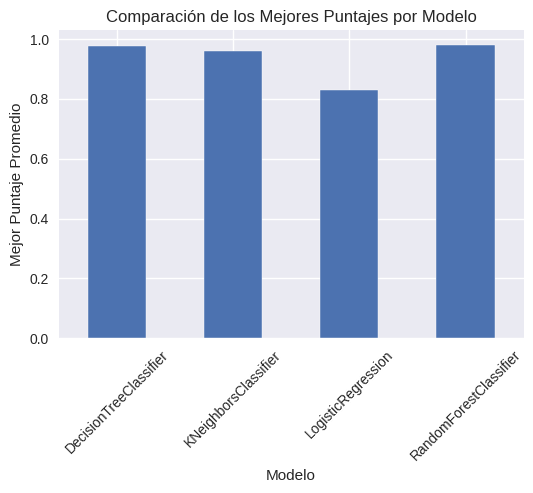

In [ ]:

best_scores_final = resultados_finales.groupby('Modelo')['Score'].max()

# Gráfica comparativa
plt.figure(figsize=(6, 4))
best_scores_final.plot(kind='bar')
plt.title('Comparación de los Mejores Puntajes por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Mejor Puntaje Promedio')
plt.xticks(rotation=45)
plt.show()

Luego de las mejoras, podemos ver que RFC sigue dando los mejores resultados, aunque de forma muy pareja con DTC y KNN. Logistic Regression sigue tienendo resultados mas moderados que los otros 3 modelos.

### Comparación Final

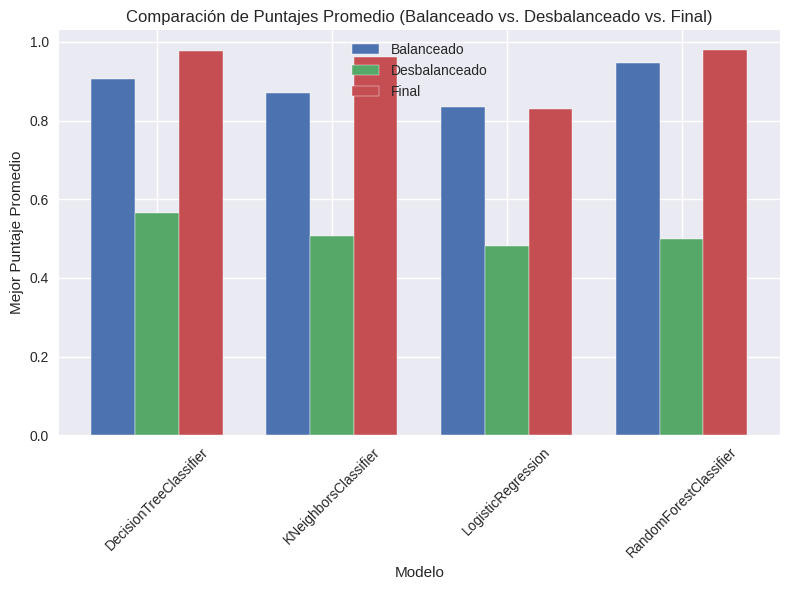

In [ ]:
model_names = best_scores_balanced.index
scores_balanced = best_scores_balanced.values
scores_imbalanced = best_scores_imbalanced.values
scores_final = best_scores_final.values

# Configuración de la gráfica
width = 0.25  # Ancho de las barras
x = np.arange(len(model_names))

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Dibuja las barras
ax.bar(x - width, scores_balanced, width, label='Balanceado')
ax.bar(x, scores_imbalanced, width, label='Desbalanceado')
ax.bar(x + width, scores_final, width, label='Final')

# Configura el título y etiquetas de los ejes
ax.set_title('Comparación de Puntajes Promedio (Balanceado vs. Desbalanceado vs. Final)')
ax.set_xlabel('Modelo')
ax.set_ylabel('Mejor Puntaje Promedio')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()

# Muestra el gráfico
plt.tight_layout()
plt.show()

## Conclusion

Hemos comenzado con modelos bastante debiles en terminos de resultados, que mejoraron ampliamente luego del balanceo de los atributos.
Luego de esa mejora se trabajo sobre los parametros y si bien los modelos ya eran muy buenos, se logro mejorar levemente los mismos.
Analizando la comparativa final, el RandomForestClassifier parece ser la mejor opción, aunque Decision Tree y KNN presentan excelentes resultados tambien. Con Logistic Regression los resultados obtenidos son buenos pero no al mismo nivel que los otros 3 modelos.